### segmentNHD

In [1]:
import os
import time

import geopandas as gpd
import pandas as pd
from pandarallel import pandarallel

from reaches import readNHD
from reaches import cut
from reaches import segmentReach

In [12]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
start = time.time()
print("hello")
end = time.time()
print(end - start)

In [2]:
# Get slurm job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
slurm = 197

In [ ]:
## Prepare data
# Read prepped NHD
basin, huc4, huc2 = readNHD(index=slurm)

In [ ]:
basin

In [46]:
test = basin.iloc[0:10]

In [47]:
test['segments'] = test.apply(func=segmentReach, axis=1)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
test =  test.explode(column='segments', index_parts=True)

In [49]:
test = test.drop(columns='geometry').set_geometry('segments').set_crs(crs=test.crs)

In [27]:
# segments = test['geometry'].apply(lambda line: segmentReach(line))

In [28]:
# segments_flat = [segment for sublist in segments for segment in sublist]

In [29]:
# Create a new GeoDataFrame from the list of new LineStrings
# new_gdf = gpd.GeoDataFrame(geometry=segments_flat, crs=test.crs)

In [30]:
# Create a new GeoDataFrame from the list of new LineStrings
# new_gdf = gpd.GeoDataFrame(geometry=segments, crs=test.crs)

In [5]:
# # Keep only reaches that were sucessfully segmented
# test = test[test['failed'] == 0]

In [6]:
# # Drop failed column
# test = test.drop(columns='failed')

In [51]:
save_path = '/nas/cee-water/cjgleason/fiona/'

In [52]:
test.to_parquet(path=save_path + 'test.parquet')

In [18]:
# Set write filepath
save_path = '../narrow_rivers_PIXC_data/NHD_prepped_segmented/'
save_path = os.path.join(save_path, huc2)
save_file = huc4 + '_prepped_segmented.parquet'

In [20]:
save_file

'NHDPLUS_H_0108_HU4_GDB_prepped_segmented.parquet'

In [25]:
basin.dtypes

Bin            object
GNIS_Name      object
LengthKM      float64
NHDPlusID     float64
WidthM        float64
geometry     geometry
segments       object
dtype: object

In [ ]:
#Write out gdf as parquet file
if not os.path.isdir(save_path):
    os.makedirs(save_path)
basin.to_parquet(path=os.path.join(save_path, save_file))

### Testing

In [1]:
import os

import geopandas as gpd ### DELETE
import matplotlib.pyplot as plt ### DELETE
import numpy as np
import pandas as pd
import shapely as shp
import xarray as xr

from shapely.geometry import MultiLineString

from reaches import readNHD
from reaches import cut
from reaches import segmentReach

In [2]:
def segmentReach(reach):
    '''
    Ths function takes a reach center line, cuts it into ten segments of
    equal length, and returns those ten segments.
    '''
    
    # Get linestring
    line = reach.geometry
    # Find length of segments
    dist = line.length/10
    
    # Make empty list for segments
    segments = []

    # Segment the reach
    for i in range(9):
        try:
            # Chop the reach, store remainder
            new, line = cut(line=line, distance=dist)
            # Append new segment to GeoSeries of all segments
            segments.append(new)
        except:
            print('Failed to segment reach: ' + reach['NHDPlusID'])
    
    # Append final segment to list
    segments.append(line)

    return segments

In [3]:
def bufferSegments(reach):
    
    # Convert list of segments to GeoSeries
    segments = gpd.GeoSeries(data=reach['segments'], crs='EPSG:3857')
    # Buffer segments
    segments_b = segments.buffer(distance=(reach.WidthM/2), cap_style='flat')
    # Convert back to list before returning
    segments_b = segments_b.geometry.tolist()
    
    return segments_b

In [4]:
index = 1

In [5]:
## Prepare data
# Read prepped NHD
basin, huc4, huc2 = readNHD(index=index)

In [6]:
huc4

'NHDPLUS_H_0102_HU4_GDB'

In [8]:
test = basin.iloc[0:10]

In [10]:
test['segments'] = test.apply(func=segmentReach, axis=1)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
test.segments.dtype

dtype('O')

In [12]:
save_path = '/nas/cee-water/cjgleason/fiona/'

In [13]:
test.to_parquet(path=save_path + 'huc4_0108_test.parquet')

In [249]:
# Buffer the reaches
basin['reach_b'] = basin.buffer(distance=(basin.WidthM/2), cap_style='flat')

In [250]:
# Segment the reaches
basin['segments'] = basin.apply(func=segmentReach, axis=1)

In [254]:
# Buffer the segments
basin['segments_b'] = basin.apply(func=bufferSegments, axis=1)

In [268]:
basin['geometry_wkt'] = basin['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)

In [261]:
basin['reach_b_wkt'] = basin['reach_b'].apply(lambda geom: geom.wkt if geom is not None else None)

In [ ]:
basin = basin.drop(columns=['geometry','reach_b'])

In [270]:
save_path = '/nas/cee-water/cjgleason/fiona/'

In [ ]:
basin.to_parquet(path=save_path + 'huc4_0108_test.parquet')

<Axes: >

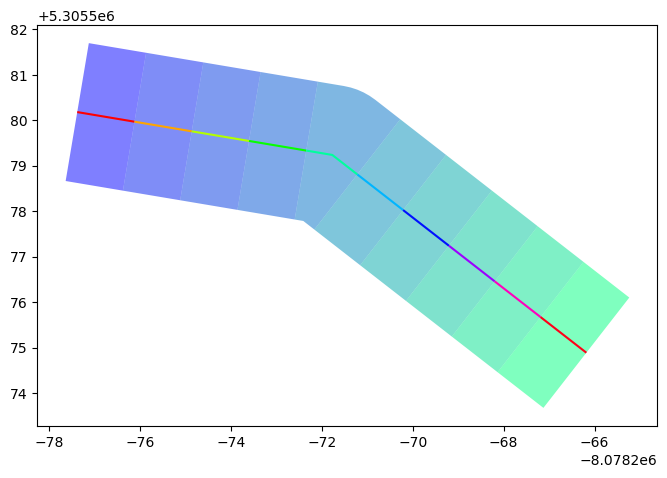

In [117]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(basin.iloc[8000].segments).plot(cmap='hsv', ax=ax)
gpd.GeoSeries(basin.iloc[8000].segments_b).plot(cmap='winter', alpha=0.5, ax=ax)

### To check once written

In [5]:
path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_17/NHDPLUS_H_1710_HU4_GDB_prepped_segmented.parquet'

In [6]:
test = gpd.read_parquet(path=path)

In [7]:
test

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,segments
0,"(0, 10]",None,0.190647,5.500010e+13,0.772382,"LINESTRING (-13828825.025 5291376.777, -138288..."
0,"(0, 10]",None,0.190647,5.500010e+13,0.772382,"LINESTRING (-13828823.11 5291350.97, -13828817..."
0,"(0, 10]",None,0.190647,5.500010e+13,0.772382,"LINESTRING (-13828817.734 5291325.599, -138288..."
0,"(0, 10]",None,0.190647,5.500010e+13,0.772382,"LINESTRING (-13828813.38 5291300.083, -1382881..."
0,"(0, 10]",None,0.190647,5.500010e+13,0.772382,"LINESTRING (-13828813.511 5291274.193, -138288..."
...,...,...,...,...,...,...
924843,"(10, 20]",West Fork Evans Creek,0.057358,5.500010e+13,14.372114,"LINESTRING (-13699396.351 5259592.381, -136993..."
924843,"(10, 20]",West Fork Evans Creek,0.057358,5.500010e+13,14.372114,"LINESTRING (-13699389.859 5259596.728, -136993..."
924843,"(10, 20]",West Fork Evans Creek,0.057358,5.500010e+13,14.372114,"LINESTRING (-13699382.968 5259600.388, -136993..."
924843,"(10, 20]",West Fork Evans Creek,0.057358,5.500010e+13,14.372114,"LINESTRING (-13699375.981 5259603.885, -136993..."
